Training a Physics-Informed Neural Network for control of dynamic system.

Use case: _Fed-Batch bioreactor with no product formation_

In [ ]:
import copy
import os
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.stats import qmc
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#################################################################   
####################Physics-Informed Neural Network #############
NUM_EPOCHS = 100000
LEARNING_RATE = 1e-4
NUM_COLLOCATION = 10000
PATIENCE = 1000
THRESHOLD = 1e-3
EARLY_STOPPING_EPOCH = 50000
NUM_SAMPLES = 3000

T_START = 0.0
T_END = 5.0
dt = 0.1

X_MIN = 3.0
X_MAX = 30.0
S_MIN = 0.01
S_MAX = 2.0
V_MIN = 1.0
V_MAX = 3.0
F_MIN = 0.0
F_MAX = 0.1

# --- Model Parameters ---
# MU_MAX = 0.86980    # 1/h
# K_S = 0.000123762    # g/l
# Y_XS = 0.435749      # g/g
S_F = 286           # g/l

# PINN estimated kinetic parameters
MU_MAX = 0.8308
K_S    = 0.1004
Y_XS   = 0.3684

# Initial Conditions
X_0, S_0, V_0 = 5, 0.013, 1.7  # Biomass, Substrate, Volume

# ODE solver parameters
ODE_SOLVER = 'LSODA'

In [ ]:
def numpy_to_tensor(array, requires_grad=False):
    return torch.tensor(array, requires_grad=requires_grad, dtype=torch.float32).to(DEVICE).reshape(-1, 1)

def grad(outputs, inputs):
    return torch.autograd.grad(outputs.sum(), inputs, create_graph=True)[0]

class PINN(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()
        self.input = nn.Linear(input_dim, 64)
        self.hidden1 = nn.Linear(64, 1024)
        self.hidden  = nn.Linear(1024, 1024)
        self.hidden2 = nn.Linear(1024, 64)
        self.output = nn.Linear(64, output_dim)
        
    def forward(self, x):
        x = torch.tanh(self.input(x))
        x = torch.tanh(self.hidden1(x))
        x = torch.tanh(self.hidden(x))
        x = torch.tanh(self.hidden2(x))
        x = self.output(x)
        return x

In [23]:
def generate_dataset(num_samples: int = NUM_SAMPLES, sampling_method: str = 'lhs') -> tuple:
    """Generate dataset of random multiple initial conditions and control actions"""
    df = pd.DataFrame(columns=['t', 'X', 'S', 'V', 'F'])
    if sampling_method == 'uniform':
        df['X'] = np.random.uniform(X_MIN, X_MAX, num_samples)
        df['S'] = np.random.uniform(S_MIN, S_MAX, num_samples)
        df['V'] = np.random.uniform(V_MIN, V_MAX, num_samples)
        df['F'] = np.random.uniform(F_MIN, F_MAX, num_samples)
        df['t'] = 0.0 # initial time (always 0)
    elif sampling_method == 'lhs':
        sampler = qmc.LatinHypercube(d=4)
        lhs_samples = sampler.random(n=num_samples)
        scaled_samples = qmc.scale(lhs_samples, [X_MIN, S_MIN, V_MIN, F_MIN], [X_MAX, S_MAX, V_MAX, F_MAX])
        df = pd.DataFrame(scaled_samples, columns=['X', 'S', 'V', 'F'])
        df['t'] = 0.0
        
    t_train = numpy_to_tensor(df['t'].values, requires_grad=True)
    X_train = numpy_to_tensor(df['X'].values)
    S_train = numpy_to_tensor(df['S'].values)
    V_train = numpy_to_tensor(df['V'].values)
    F_train = numpy_to_tensor(df['F'].values)
    
    in_train = torch.cat([t_train, X_train, S_train, V_train, F_train], dim=1)
    out_train = torch.cat([X_train, S_train, V_train], dim=1)
    
    return in_train, out_train

def loss_fn(net: nn.Module, sampling_method: str = 'lhs') -> torch.Tensor:
    if sampling_method == 'uniform':
        t_col = numpy_to_tensor(np.random.uniform(T_START, dt, NUM_COLLOCATION), requires_grad=True)
        X0_col = numpy_to_tensor(np.random.uniform(X_MIN, X_MAX, NUM_COLLOCATION))
        S0_col = numpy_to_tensor(np.random.uniform(S_MIN, S_MAX, NUM_COLLOCATION))
        V0_col = numpy_to_tensor(np.random.uniform(V_MIN, V_MAX, NUM_COLLOCATION))
        F_col  = numpy_to_tensor(np.random.uniform(F_MIN, F_MAX, NUM_COLLOCATION))
    elif sampling_method == 'lhs':
        sampler = qmc.LatinHypercube(d=5)
        lhs_samples = sampler.random(n=NUM_COLLOCATION)
        scaled_samples = qmc.scale(lhs_samples, [T_START, X_MIN, S_MIN, V_MIN, F_MIN], [dt, X_MAX, S_MAX, V_MAX, F_MAX])
        t_col = numpy_to_tensor(scaled_samples[:, 0], requires_grad=True)
        X0_col = numpy_to_tensor(scaled_samples[:, 1])
        S0_col = numpy_to_tensor(scaled_samples[:, 2])
        V0_col = numpy_to_tensor(scaled_samples[:, 3])
        F_col  = numpy_to_tensor(scaled_samples[:, 4])
    
    u_col = torch.cat([t_col, X0_col, S0_col, V0_col, F_col], dim=1)
    preds = net.forward(u_col)

    X_pred = preds[:, 0].view(-1, 1)
    S_pred = preds[:, 1].view(-1, 1)
    V_pred = preds[:, 2].view(-1, 1)
    # V_pred = V0_col.view(-1, 1)  # Use the initial volume for the prediction

    dXdt_pred = grad(X_pred, t_col)
    dSdt_pred = grad(S_pred, t_col) 
    dVdt_pred = grad(V_pred, t_col) # not used

    mu = MU_MAX * S_pred / (K_S + S_pred)

    # residuals
    rhs_X = mu * X_pred - (F_col / V_pred) * X_pred
    rhs_S = - (mu * X_pred) / Y_XS + (F_col / V_pred) * (S_F - S_pred)
    rhs_V = F_col

    error_dXdt = dXdt_pred - rhs_X
    error_dSdt = dSdt_pred - rhs_S
    error_dVdt = dVdt_pred - rhs_V

    # average residual squared loss
    w_X, w_S, w_V = 0.8, 0.2, 0.0
    loss_ode = torch.mean(error_dXdt**2) * w_X + \
               torch.mean(error_dSdt**2) * w_S + \
               torch.mean(error_dVdt**2) * w_V

    return loss_ode


In [24]:
in_train, out_train = generate_dataset()

print(f'Input shape: {in_train.shape}')
print(f'Output shape: {out_train.shape}')

Input shape: torch.Size([3000, 5])
Output shape: torch.Size([3000, 3])


In [25]:
model_name = "pinc_model_br.pth"
model_exists = os.path.exists(f'./models/{model_name}')

if model_exists:
    # Load the model
    net = PINN(input_dim=in_train.shape[1], output_dim=out_train.shape[1]).to(DEVICE)
    net.load_state_dict(torch.load(f'./models/{model_name}', weights_only=True))
    net.eval()
else:
    # Main
    net = PINN(input_dim=in_train.shape[1], output_dim=out_train.shape[1]).to(DEVICE)
    optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.75)

    # Loss weights
    w_data, w_ode, w_ic = 1, 1, 0.0

    # Initialize early stopping variables
    best_loss = float("inf")
    best_model_weights = None
    patience = PATIENCE
    threshold = THRESHOLD
    pretrain_epochs = 0
    
    for epoch in tqdm(range(NUM_EPOCHS)):
        optimizer.zero_grad()
        preds = net.forward(in_train)
        X_pred = preds[:, 0].view(-1, 1)
        S_pred = preds[:, 1].view(-1, 1)
        V_pred = preds[:, 2].view(-1, 1)
        
        w_X, w_S, w_V = 0.7, 0.2, 0.1
        loss_data = torch.mean((X_pred - out_train[:, 0].view(-1, 1))**2) * w_X + \
                    torch.mean((S_pred - out_train[:, 1].view(-1, 1))**2) * w_S + \
                    torch.mean((V_pred - out_train[:, 2].view(-1, 1))**2) * w_V
        
        if epoch < pretrain_epochs:
            loss = loss_data * w_data
        else:
            loss_ode = loss_fn(net)
            loss = w_data * loss_data + w_ode * loss_ode
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        if epoch % 1000 == 0:
            if epoch < pretrain_epochs:
                print(f"Epoch {epoch}: Loss = {loss_data.item():.4f}")
            else:
                print(f"Epoch {epoch}: Loss = {loss.item():.4f}, Data Loss = {loss_data.item():.4f}, ODE Loss = {loss_ode.item():.4f}")
        
        # Early stopping
        if epoch >= EARLY_STOPPING_EPOCH:
            if loss.item() < best_loss - threshold:
                best_loss = loss.item()
                best_model_weights = copy.deepcopy(net.state_dict())
                patience = PATIENCE
            else:
                patience -= 1
                if patience <= 0:
                    print(f"Early stopping at epoch {epoch}. Best loss: {best_loss:.4f} at epoch {epoch - PATIENCE}.")
                    break

    # Load best model weights
    if best_model_weights is not None:
        net.load_state_dict(best_model_weights)
        net.eval()
        print("Loaded best model weights.")
    else:
        print("No model weights to load.")
        net.eval()

    # Save the model
    torch.save(net.state_dict(), f'./models/{model_name}')


  0%|          | 7/100000 [00:00<25:07, 66.33it/s]

Epoch 0: Loss = 5675368.0000, Data Loss = 229.4039, ODE Loss = 5675138.5000


  1%|          | 1011/100000 [00:12<21:38, 76.26it/s]

Epoch 1000: Loss = 407.2143, Data Loss = 206.8342, ODE Loss = 200.3801


  2%|▏         | 2014/100000 [00:25<20:46, 78.60it/s]

Epoch 2000: Loss = 370.2759, Data Loss = 190.6107, ODE Loss = 179.6652


  3%|▎         | 3012/100000 [00:38<20:25, 79.14it/s]

Epoch 3000: Loss = 352.9498, Data Loss = 178.5641, ODE Loss = 174.3857


  4%|▍         | 4011/100000 [00:50<17:56, 89.20it/s]

Epoch 4000: Loss = 336.2300, Data Loss = 166.4191, ODE Loss = 169.8110


  5%|▌         | 5012/100000 [01:03<18:30, 85.56it/s]

Epoch 5000: Loss = 324.1716, Data Loss = 157.3165, ODE Loss = 166.8550


  6%|▌         | 6010/100000 [01:16<20:46, 75.38it/s]

Epoch 6000: Loss = 313.4555, Data Loss = 148.2831, ODE Loss = 165.1724


  7%|▋         | 7011/100000 [01:29<20:23, 75.99it/s]

Epoch 7000: Loss = 305.5738, Data Loss = 141.6022, ODE Loss = 163.9716


  8%|▊         | 8014/100000 [01:42<19:50, 77.24it/s]

Epoch 8000: Loss = 297.7894, Data Loss = 135.0314, ODE Loss = 162.7580


  9%|▉         | 9010/100000 [01:55<18:45, 80.85it/s]

Epoch 9000: Loss = 291.7191, Data Loss = 130.1785, ODE Loss = 161.5407


 10%|█         | 10013/100000 [02:08<19:24, 77.26it/s]

Epoch 10000: Loss = 285.6036, Data Loss = 125.3708, ODE Loss = 160.2328


 11%|█         | 11014/100000 [02:21<19:20, 76.66it/s]

Epoch 11000: Loss = 280.9963, Data Loss = 121.7670, ODE Loss = 159.2292


 12%|█▏        | 12011/100000 [02:34<18:39, 78.57it/s]

Epoch 12000: Loss = 276.2583, Data Loss = 118.1101, ODE Loss = 158.1482


 13%|█▎        | 13017/100000 [02:47<17:04, 84.89it/s]

Epoch 13000: Loss = 272.2055, Data Loss = 115.2765, ODE Loss = 156.9290


 14%|█▍        | 14016/100000 [03:00<18:12, 78.72it/s]

Epoch 14000: Loss = 267.4863, Data Loss = 112.2701, ODE Loss = 155.2162


 15%|█▌        | 15008/100000 [03:13<18:41, 75.76it/s]

Epoch 15000: Loss = 263.3155, Data Loss = 109.8199, ODE Loss = 153.4956


 16%|█▌        | 16013/100000 [03:26<18:38, 75.09it/s]

Epoch 16000: Loss = 257.5087, Data Loss = 107.0868, ODE Loss = 150.4220


 17%|█▋        | 17015/100000 [03:39<18:05, 76.47it/s]

Epoch 17000: Loss = 251.8397, Data Loss = 104.7572, ODE Loss = 147.0825


 18%|█▊        | 18010/100000 [03:52<18:10, 75.19it/s]

Epoch 18000: Loss = 244.9109, Data Loss = 102.0484, ODE Loss = 142.8625


 19%|█▉        | 19011/100000 [04:05<18:02, 74.84it/s]

Epoch 19000: Loss = 237.5276, Data Loss = 99.5931, ODE Loss = 137.9344


 20%|██        | 20014/100000 [04:18<17:37, 75.64it/s]

Epoch 20000: Loss = 226.4754, Data Loss = 96.5002, ODE Loss = 129.9752


 21%|██        | 21011/100000 [04:31<16:47, 78.39it/s]

Epoch 21000: Loss = 215.7364, Data Loss = 93.4576, ODE Loss = 122.2788


 22%|██▏       | 22012/100000 [04:44<17:23, 74.71it/s]

Epoch 22000: Loss = 201.7235, Data Loss = 89.3507, ODE Loss = 112.3728


 23%|██▎       | 23009/100000 [04:57<17:48, 72.07it/s]

Epoch 23000: Loss = 187.4481, Data Loss = 85.1233, ODE Loss = 102.3248


 24%|██▍       | 24009/100000 [05:11<16:16, 77.79it/s]

Epoch 24000: Loss = 169.1682, Data Loss = 79.3373, ODE Loss = 89.8309


 25%|██▌       | 25013/100000 [05:23<16:33, 75.51it/s]

Epoch 25000: Loss = 152.3898, Data Loss = 73.4885, ODE Loss = 78.9013


 26%|██▌       | 26015/100000 [05:37<16:01, 76.97it/s]

Epoch 26000: Loss = 132.4346, Data Loss = 65.8849, ODE Loss = 66.5497


 27%|██▋       | 27015/100000 [05:50<15:55, 76.42it/s]

Epoch 27000: Loss = 115.3925, Data Loss = 58.8173, ODE Loss = 56.5752


 28%|██▊       | 28011/100000 [06:03<16:21, 73.38it/s]

Epoch 28000: Loss = 97.1686, Data Loss = 50.6862, ODE Loss = 46.4823


 29%|██▉       | 29013/100000 [06:16<15:53, 74.43it/s]

Epoch 29000: Loss = 83.0949, Data Loss = 44.2756, ODE Loss = 38.8193


 30%|███       | 30014/100000 [06:30<15:25, 75.61it/s]

Epoch 30000: Loss = 69.9186, Data Loss = 38.3420, ODE Loss = 31.5767


 31%|███       | 31015/100000 [06:43<14:38, 78.57it/s]

Epoch 31000: Loss = 61.2774, Data Loss = 34.8121, ODE Loss = 26.4653


 32%|███▏      | 32010/100000 [06:56<14:34, 77.71it/s]

Epoch 32000: Loss = 54.2379, Data Loss = 32.4761, ODE Loss = 21.7618


 33%|███▎      | 33012/100000 [07:09<14:17, 78.10it/s]

Epoch 33000: Loss = 50.0918, Data Loss = 31.4233, ODE Loss = 18.6685


 34%|███▍      | 34009/100000 [07:22<14:07, 77.86it/s]

Epoch 34000: Loss = 46.3394, Data Loss = 30.5534, ODE Loss = 15.7860


 35%|███▌      | 35016/100000 [07:35<15:02, 72.03it/s]

Epoch 35000: Loss = 43.4868, Data Loss = 29.6953, ODE Loss = 13.7915


 36%|███▌      | 36011/100000 [07:48<13:54, 76.67it/s]

Epoch 36000: Loss = 40.3476, Data Loss = 28.4663, ODE Loss = 11.8813


 37%|███▋      | 37015/100000 [08:01<13:53, 75.53it/s]

Epoch 37000: Loss = 37.8269, Data Loss = 27.2277, ODE Loss = 10.5992


 38%|███▊      | 38017/100000 [08:14<12:59, 79.47it/s]

Epoch 38000: Loss = 34.9639, Data Loss = 25.6598, ODE Loss = 9.3041


 39%|███▉      | 39010/100000 [08:27<13:10, 77.16it/s]

Epoch 39000: Loss = 32.6169, Data Loss = 24.2524, ODE Loss = 8.3646


 40%|████      | 40015/100000 [08:40<12:57, 77.11it/s]

Epoch 40000: Loss = 30.1966, Data Loss = 22.6402, ODE Loss = 7.5564


 41%|████      | 41011/100000 [08:53<12:45, 77.07it/s]

Epoch 41000: Loss = 28.2976, Data Loss = 21.3278, ODE Loss = 6.9698


 42%|████▏     | 42011/100000 [09:06<12:45, 75.79it/s]

Epoch 42000: Loss = 26.4168, Data Loss = 19.9623, ODE Loss = 6.4545


 43%|████▎     | 43015/100000 [09:19<12:36, 75.29it/s]

Epoch 43000: Loss = 24.8977, Data Loss = 18.9286, ODE Loss = 5.9691


 44%|████▍     | 44012/100000 [09:32<12:16, 75.98it/s]

Epoch 44000: Loss = 23.5684, Data Loss = 17.9107, ODE Loss = 5.6577


 45%|████▌     | 45009/100000 [09:45<11:43, 78.18it/s]

Epoch 45000: Loss = 22.7014, Data Loss = 17.2298, ODE Loss = 5.4715


 46%|████▌     | 46016/100000 [09:58<11:50, 75.93it/s]

Epoch 46000: Loss = 22.0007, Data Loss = 16.7820, ODE Loss = 5.2187


 47%|████▋     | 47015/100000 [10:11<11:16, 78.37it/s]

Epoch 47000: Loss = 21.7264, Data Loss = 16.5407, ODE Loss = 5.1857


 48%|████▊     | 48016/100000 [10:24<11:31, 75.21it/s]

Epoch 48000: Loss = 21.3415, Data Loss = 16.2858, ODE Loss = 5.0557


 49%|████▉     | 49009/100000 [10:37<10:57, 77.51it/s]

Epoch 49000: Loss = 21.1608, Data Loss = 16.1762, ODE Loss = 4.9847


 50%|█████     | 50014/100000 [10:49<10:39, 78.17it/s]

Epoch 50000: Loss = 21.1248, Data Loss = 16.0433, ODE Loss = 5.0816


 51%|█████     | 51010/100000 [11:02<10:40, 76.55it/s]

Epoch 51000: Loss = 20.9945, Data Loss = 15.9698, ODE Loss = 5.0247


 52%|█████▏    | 52014/100000 [11:15<10:23, 76.94it/s]

Epoch 52000: Loss = 20.7298, Data Loss = 15.8962, ODE Loss = 4.8336


 53%|█████▎    | 53011/100000 [11:28<10:09, 77.13it/s]

Epoch 53000: Loss = 20.6509, Data Loss = 15.8272, ODE Loss = 4.8237


 54%|█████▍    | 54010/100000 [11:41<10:31, 72.85it/s]

Epoch 54000: Loss = 20.6414, Data Loss = 15.7511, ODE Loss = 4.8903


 55%|█████▌    | 55016/100000 [11:54<09:43, 77.03it/s]

Epoch 55000: Loss = 20.5259, Data Loss = 15.6837, ODE Loss = 4.8422


 56%|█████▌    | 56010/100000 [12:06<09:43, 75.44it/s]

Epoch 56000: Loss = 20.4813, Data Loss = 15.6131, ODE Loss = 4.8682


 57%|█████▋    | 57010/100000 [12:19<09:16, 77.25it/s]

Epoch 57000: Loss = 20.4422, Data Loss = 15.5823, ODE Loss = 4.8599


 58%|█████▊    | 58011/100000 [12:32<09:03, 77.22it/s]

Epoch 58000: Loss = 20.3146, Data Loss = 15.5465, ODE Loss = 4.7681


 59%|█████▉    | 59012/100000 [12:45<08:56, 76.41it/s]

Epoch 59000: Loss = 20.3841, Data Loss = 15.5240, ODE Loss = 4.8600


 60%|██████    | 60011/100000 [12:58<08:33, 77.82it/s]

Epoch 60000: Loss = 20.3390, Data Loss = 15.4945, ODE Loss = 4.8445


 61%|██████    | 61011/100000 [13:11<08:54, 72.97it/s]

Epoch 61000: Loss = 20.2569, Data Loss = 15.4668, ODE Loss = 4.7902


 62%|██████▏   | 62013/100000 [13:24<08:13, 76.97it/s]

Epoch 62000: Loss = 20.2379, Data Loss = 15.4338, ODE Loss = 4.8042


 63%|██████▎   | 63010/100000 [13:37<07:54, 77.94it/s]

Epoch 63000: Loss = 20.1852, Data Loss = 15.4058, ODE Loss = 4.7794


 64%|██████▍   | 64013/100000 [13:50<08:08, 73.59it/s]

Epoch 64000: Loss = 20.1431, Data Loss = 15.3826, ODE Loss = 4.7605


 65%|██████▌   | 65016/100000 [14:03<07:37, 76.54it/s]

Epoch 65000: Loss = 20.1375, Data Loss = 15.3683, ODE Loss = 4.7692


 65%|██████▌   | 65170/100000 [14:05<07:31, 77.07it/s]

Early stopping at epoch 65170. Best loss: 19.9916 at epoch 64170.
Loaded best model weights.


In [26]:
# Load the model
net = PINN(input_dim=in_train.shape[1], output_dim=out_train.shape[1]).to(DEVICE)

net.load_state_dict(torch.load(f'./models/{model_name}', weights_only=True))
net.eval()

def flow_rate(t: float) -> float:
    """Flow rate as a function of time"""
    if t < 0.5:
        return 0.01
    elif t < 5.0:
        return 0.1
    else:
        return 0.00

# System dynamics
def system_dynamics(t: float, y: float, F: Union[callable, float]) -> np.array:
    X, S, V = y
    Fs = F(t) if callable(F) else F
    dX_dt = (MU_MAX * S / (K_S + S)) * X - (Fs / V) * X
    dS_dt = -(1 / Y_XS) * (MU_MAX * S / (K_S + S)) * X + (Fs / V) * (S_F - S)
    dV_dt = Fs
    return np.array([dX_dt, dS_dt, dV_dt])

def solve_ode(ode: callable, t_span: list, y0: list, method: str, t_eval: list, args: tuple) -> solve_ivp:
    sol = solve_ivp(ode, t_span=t_span, y0=y0, method=method, args=args, t_eval=t_eval, rtol=1e-6, atol=1e-12)
    # sol.y = np.maximum(sol.y, 0)
    return sol

sol = solve_ode(system_dynamics, t_span=[T_START, T_END], y0=[X_0, S_0, V_0], method=ODE_SOLVER, \
                t_eval=np.arange(T_START, T_END, dt), args=(flow_rate,))
df = pd.DataFrame(sol.y.T, columns=['X', 'S', 'V'])
df['Time'] = sol.t

T_s = 0.1
t_test = numpy_to_tensor(np.array([df['Time'].values]))
X_test = numpy_to_tensor(np.array([df['X'].values]))
S_test = numpy_to_tensor(np.array([df['S'].values]))
V_test = numpy_to_tensor(np.array([df['V'].values]))
F_test = numpy_to_tensor(np.array([flow_rate(t) for t in df['Time'].values]))
u_test = torch.cat([t_test, X_test, S_test, V_test, F_test], dim=1)
x_test = torch.cat([X_test, S_test, V_test], dim=1)

X_0 = X_test[0]
S_0 = S_test[0]
V_0 = V_test[0]
F_0 = F_test[0]

X_preds = []
S_preds = []
V_preds = []

net.eval()
for i in range(len(u_test)):

    if i == 0:
        X_preds.append(X_0.item())
        S_preds.append(S_0.item())
        V_preds.append(V_0.item())
        continue

    x_k = net.forward(torch.tensor([T_s, X_0, S_0, V_0, F_0], dtype=torch.float32).to(DEVICE))
    X_0 = X_test[i]
    S_0 = S_test[i]
    V_0 = V_test[i]
    F_0 = F_test[i]
    X_preds.append(x_k[0].item())
    S_preds.append(x_k[1].item())
    V_preds.append(x_k[2].item())

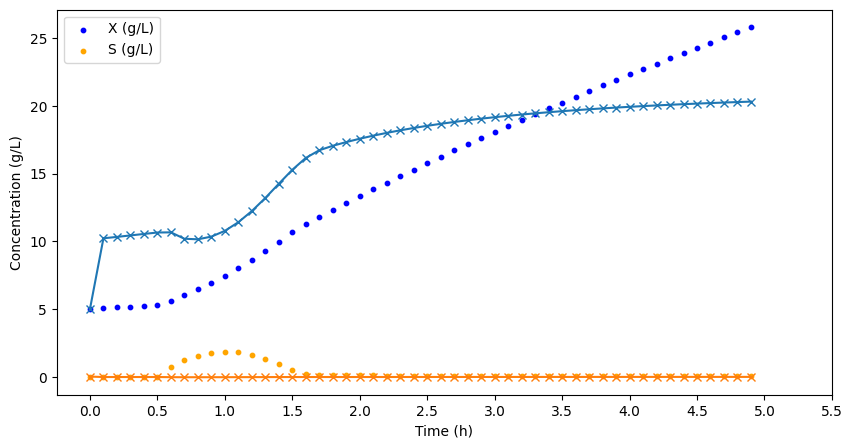

In [27]:
plt.figure(figsize=(10, 5))
plt.scatter(df['Time'], df['X'], label='X (g/L)', color='blue', s=10)
plt.scatter(df['Time'], df['S'], label='S (g/L)', color='orange', s=10)

plt.plot(t_test.detach().cpu().numpy(), X_preds, marker='x', label="_X_pred")
plt.plot(t_test.detach().cpu().numpy(), S_preds, marker='x', label="_S_pred")
plt.ylabel("Concentration (g/L)")
plt.legend(loc="best") 

plt.xticks(np.arange(0, 6, 0.5))
plt.xlabel("Time (h)")
plt.show()